In [14]:
!pip install seaborn 
!pip install pandas
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [16]:

import pandas as pd
import os
def getAffiliation(string):
    affDict = {
        'R': 
            [
                'Trump',
                'Dahle',
                'Trimino',
                'Cox',
                'Lombardo',
                'Laxalt',
                'Lake',
                'Ducey',
                'Ronchetti',
                'Pearce',
                'Abbott',
                'DeSantis'
            ],
        'D': 
            [
                'Biden',
                'Newsom',
                'Sisolak',
                'Hobbs',
                'Grisham',
                'Beto',
                'Crist',
                'Gillum',
                'Valdez'
            ]
    }
    
    for key, entities in affDict.items():
        for entity in entities:
            if entity.lower() in str(string).lower():
                return key
    # print(f"No affiliation found for {string}")
    return None
directory = './data'  # Replace with actual path
all_data = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        try:
            df = pd.read_csv(file_path)
        except:
            continue
        
        affiliation = getAffiliation(filename)
        df['Affiliation'] = affiliation
        all_data.append(df)

df = pd.concat(all_data, ignore_index=True)
df = df.drop_duplicates(subset=['ad_creative_bodies']).reset_index(drop=True)
# df1 = pd.read_csv('data/ads_all.csv')
# df2 = pd.read_csv('data/new_ads_all.csv')
# df = pd.concat([df1, df2], ignore_index=True)
# df = df.drop_duplicates(subset=['ad_creative_bodies'])
# df.columns
df_debate = pd.read_excel('kl/2020_pres_debate_translated.xlsx')
df_debate['Affiliation'] = df_debate.apply(lambda x: getAffiliation(x['Speaker ']), axis=1)
df_debate.dropna(inplace=True)
# csv of parties and rows are the names of candidates
# compare the sentiment delta to below
# ==============================================================================

#
df_debate = df_debate.rename(columns={"Speaker ": "Entity", "Verbatim":"English", "Spanish Translation ": "Spanish"})
df_debate['languages'] = 'en'
df = df.rename(columns={"page_name": "Entity"})
df = df[['Entity', 'ad_creative_bodies', 'languages', 'Affiliation']]
df['English'] = ""
df['Spanish'] = ""
df['languages'] = df.apply(lambda row: 'en' if row['languages']=="['en']" else row['languages'], axis=1)
df['languages'] = df.apply(lambda row: 'es' if row['languages']=="['es']" else row['languages'], axis=1)
df['ad_creative_bodies'] = df['ad_creative_bodies'].apply(lambda x: str(x).replace('"', '').replace("['", '').replace("']", '').replace("[", '').replace("]", ''))

df['English'] = df.apply(lambda row: row['ad_creative_bodies'] if row['languages']=='en' else '', axis=1)
df['Spanish'] = df.apply(lambda row: row['ad_creative_bodies'] if row['languages']=='es' else '', axis=1)
del df['ad_creative_bodies']
df = df[df['languages']!="['en', 'es']"]

df_analysis = pd.concat([df, df_debate]).reset_index(drop=True)

# pull a standard spanish, english training dataset
    # baseline for the sentiment model
# calculate the delta of translation which is separate from the sentimate delta, w/ the same dataset?
# ==============================================================================
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import numpy as np

class SentimentClassifier:
    def __init__(self, model_name):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(model_name)

    def classify(self, text):
        # Tokenize the input text and obtain model outputs
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.model(**inputs).logits
            probs = softmax(outputs, dim=1)
            rating = torch.dot(probs.view(-1), torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])).item()
            # label = torch.argmax(probs, dim=1).item()

        return np.round(rating, 4)

classifier = SentimentClassifier("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [28]:
import pandas as pd
import os



# Load the debate data
df_debate = pd.read_excel('kl/2020_pres_debate_translated.xlsx')
df_debate.dropna(inplace=True)

#
df_debate = df_debate.rename(columns={"Speaker ": "Entity", "Verbatim":"English", "Spanish Translation ": "Spanish"})
df_debate['languages'] = 'en'

# pull a standard spanish, english training dataset
    # baseline for the sentiment model
# calculate the delta of translation which is separate from the sentimate delta, w/ the same dataset?
# ==============================================================================
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import numpy as np

class SentimentClassifier:
    def __init__(self, model_name):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(model_name)

    def classify(self, text):
        # Tokenize the input text and obtain model outputs
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.model(**inputs).logits
            probs = softmax(outputs, dim=1)
            rating = torch.dot(probs.view(-1), torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])).item()
            # label = torch.argmax(probs, dim=1).item()

        return np.round(rating, 4)

# Analyze sentiment for English and its Spanish translation in the debate data
df_debate['English_Sentiment'] = df_debate['English'].apply(lambda x: classifier.classify(x))
df_debate['Spanish_Sentiment'] = df_debate['Spanish'].apply(lambda x: classifier.classify(x))

# Calculate the sentiment difference
df_debate['Sentiment_Difference'] = df_debate['English_Sentiment'] - df_debate['Spanish_Sentiment']




Average Sentiment Difference: 0.0752


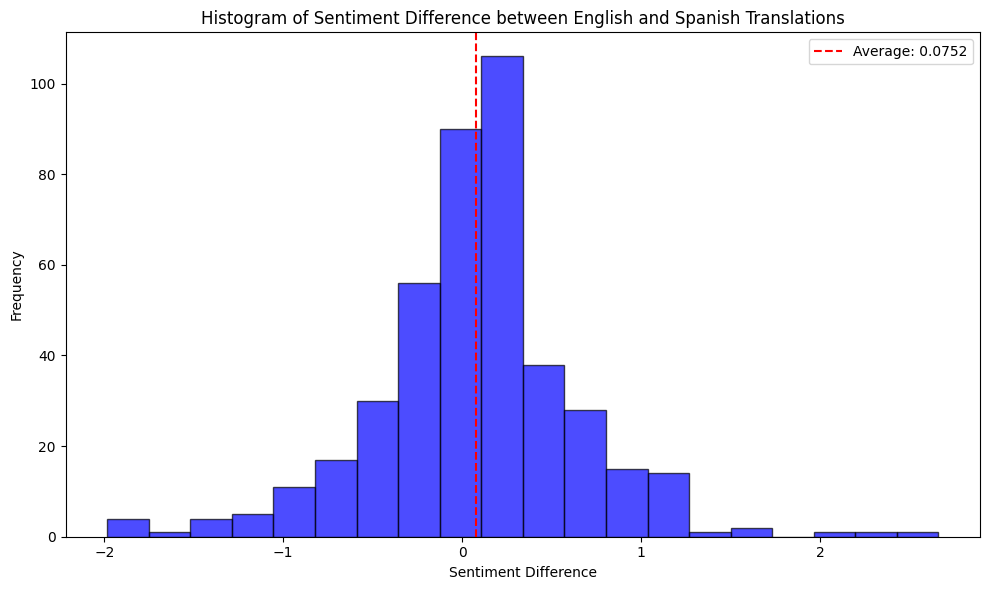

In [29]:
# Calculate the average sentiment difference
avg_sentiment_difference = df_debate['Sentiment_Difference'].mean()
print(f"\nAverage Sentiment Difference: {avg_sentiment_difference:.4f}")

# Plot a histogram to illustrate the sentiment difference
plt.figure(figsize=(10, 6))
plt.hist(df_debate['Sentiment_Difference'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=avg_sentiment_difference, color='red', linestyle='--', label=f'Average: {avg_sentiment_difference:.4f}')
plt.xlabel('Sentiment Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Difference between English and Spanish Translations')
plt.legend()
plt.tight_layout()
plt.show()


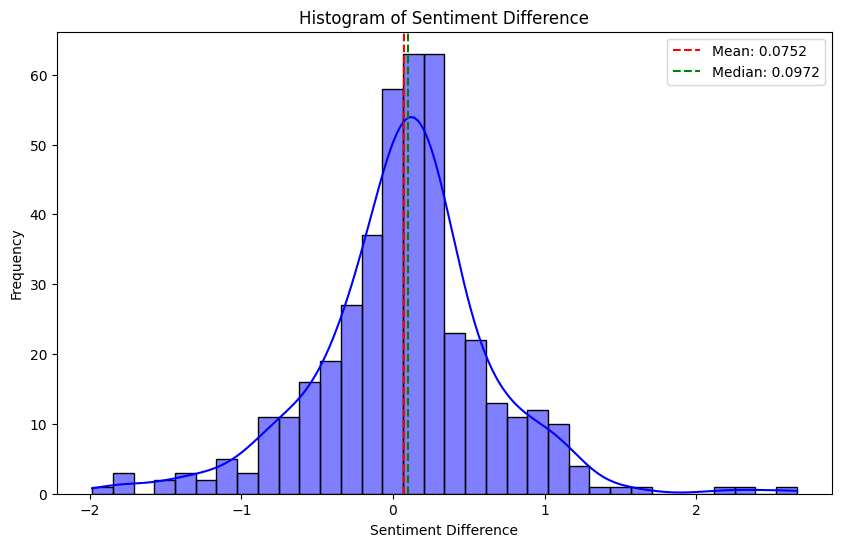

Skewness of Sentiment Difference: 0.002441


In [32]:
 sentiment_difference_skewness = df_debate['Sentiment_Difference'].skew()

# Plot a histogram for Sentiment Difference
plt.figure(figsize=(10, 6))
sns.histplot(df_debate['Sentiment_Difference'], kde=True, color='blue')
plt.axvline(x=df_debate['Sentiment_Difference'].mean(), color='red', linestyle='--', label=f'Mean: {df_debate["Sentiment_Difference"].mean():.4f}')
plt.axvline(x=df_debate['Sentiment_Difference'].median(), color='green', linestyle='--', label=f'Median: {df_debate["Sentiment_Difference"].median():.4f}')
plt.title('Histogram of Sentiment Difference')
plt.xlabel('Sentiment Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Display the skewness value
print(f"Skewness of Sentiment Difference: {sentiment_difference_skewness:.6f}")

In [35]:
import scipy.stats as stats

def tTest(groupA, groupB, alternative='two-sided'):
    equal_var = False
    # If the ratio of the larger sample variance to the smaller sample variance is less than 4. This means we can assume that the population variances are equal.
    if max(np.var(groupA), np.var(groupB)) / min(np.var(groupA), np.var(groupB)) < 4:
        equal_var = True

    #perform two sample t-test with equal variances
    return stats.ttest_ind(a=groupA, b=groupB, equal_var=equal_var, alternative=alternative)

    
# plotting raw sentiments for spanish vs english ads (regardless of par

/Users/adarshapoudel/Desktop/geometry of data/graph
T-test Result (Spanish Sentiment): T-statistic = -3.2495, p-value = 0.0020
T-test Result (English Sentiment): T-statistic = 1.7040, p-value = 0.0887
T-test Result (ES-EN Shift): T-statistic = 0.8315, p-value = 0.4093
T-test Result (EN-ES Shift): T-statistic = -2.4012, p-value = 0.0165


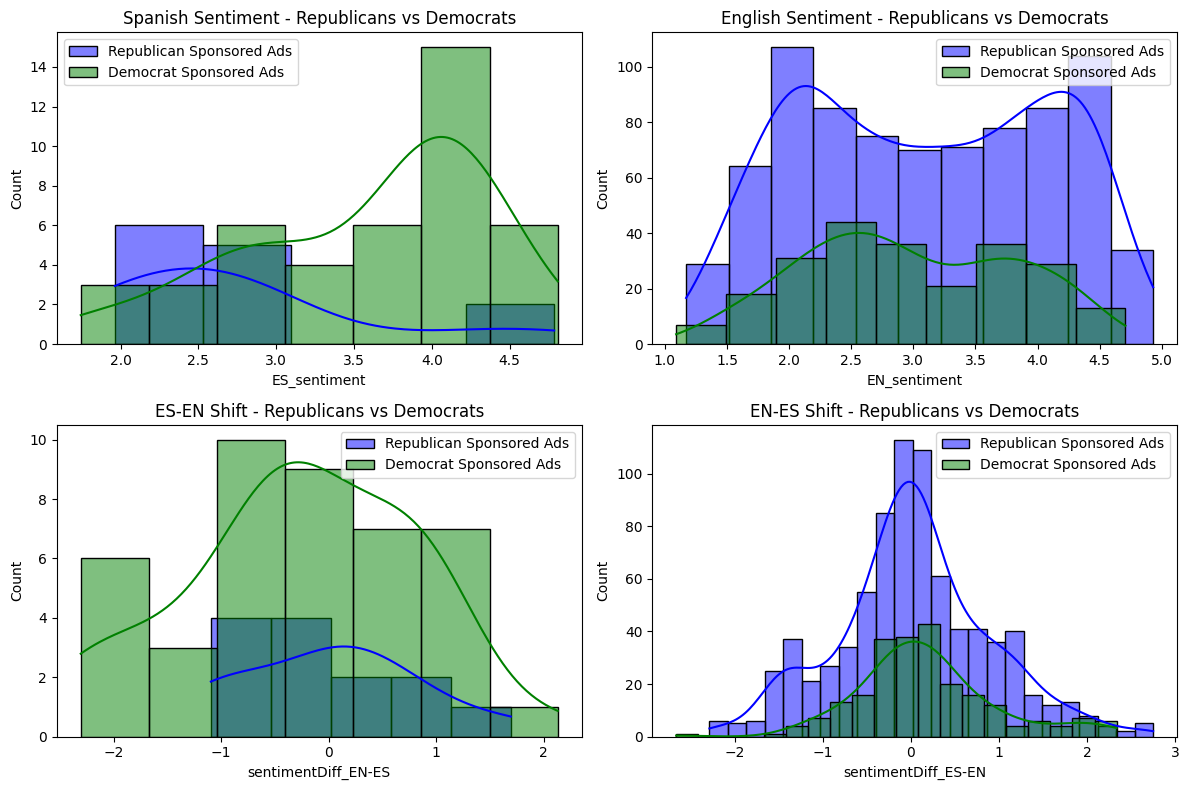

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# Load data from analysis.csv
print(os.getcwd())
df_analysis = pd.read_csv('./analysis.csv')

# Raw Sentiment between languages
# Raw sentiment based on party, Spanish
groupES_R = df_analysis[(df_analysis['languages'] == 'es') & (df_analysis['Affiliation'] == 'R')]['ES_sentiment']
groupES_D = df_analysis[(df_analysis['languages'] == 'es') & (df_analysis['Affiliation'] == 'D')]['ES_sentiment']

# Raw Sentiment based on party, English
groupEN_R = df_analysis[(df_analysis['languages'] == 'en') & (df_analysis['Affiliation'] == 'R')]['EN_sentiment']
groupEN_D = df_analysis[(df_analysis['languages'] == 'en') & (df_analysis['Affiliation'] == 'D')]['EN_sentiment']

# Filter data for each group
groupA_ES_EN = df_analysis[(df_analysis['languages'] == 'es') & (df_analysis['Affiliation'] == 'R')]['sentimentDiff_EN-ES']
groupB_ES_EN = df_analysis[(df_analysis['languages'] == 'es') & (df_analysis['Affiliation'] == 'D')]['sentimentDiff_EN-ES']

groupA_EN_ES = df_analysis[(df_analysis['languages'] == 'en') & (df_analysis['Affiliation'] == 'R')]['sentimentDiff_ES-EN']
groupB_EN_ES = df_analysis[(df_analysis['languages'] == 'en') & (df_analysis['Affiliation'] == 'D')]['sentimentDiff_ES-EN']

# Plotting
# Plotting raw sentiment based on party
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(groupES_R, kde=True, color='blue', label="Republican Sponsored Ads")
sns.histplot(groupES_D, kde=True, color='green', label="Democrat Sponsored Ads")
plt.legend()
plt.title('Spanish Sentiment - Republicans vs Democrats')

# T-test for Spanish Sentiment
t_stat_ES, p_value_ES = stats.ttest_ind(groupES_R, groupES_D)
print(f"T-test Result (Spanish Sentiment): T-statistic = {t_stat_ES:.4f}, p-value = {p_value_ES:.4f}")

plt.subplot(2, 2, 2)
# Plotting raw sentiment based on party - English
sns.histplot(groupEN_R, kde=True, color='blue', label="Republican Sponsored Ads")
sns.histplot(groupEN_D, kde=True, color='green', label="Democrat Sponsored Ads")
plt.legend()
plt.title('English Sentiment - Republicans vs Democrats')

# T-test for English Sentiment
t_stat_EN, p_value_EN = stats.ttest_ind(groupEN_R, groupEN_D)
print(f"T-test Result (English Sentiment): T-statistic = {t_stat_EN:.4f}, p-value = {p_value_EN:.4f}")

plt.subplot(2, 2, 3)
# ES-EN Shift - Republicans vs Democrats
sns.histplot(groupA_ES_EN, kde=True, color='blue', label="Republican Sponsored Ads")
sns.histplot(groupB_ES_EN, kde=True, color='green', label="Democrat Sponsored Ads")
plt.legend()
plt.title('ES-EN Shift - Republicans vs Democrats')

# T-test for ES-EN Shift
t_stat_ES_EN, p_value_ES_EN = stats.ttest_ind(groupA_ES_EN, groupB_ES_EN)
print(f"T-test Result (ES-EN Shift): T-statistic = {t_stat_ES_EN:.4f}, p-value = {p_value_ES_EN:.4f}")

plt.subplot(2, 2, 4)
# EN-ES Shift - Republicans vs Democrats
sns.histplot(groupA_EN_ES, kde=True, color='blue', label="Republican Sponsored Ads")
sns.histplot(groupB_EN_ES, kde=True, color='green', label="Democrat Sponsored Ads")
plt.legend()
plt.title('EN-ES Shift - Republicans vs Democrats')

# T-test for EN-ES Shift
t_stat_EN_ES, p_value_EN_ES = stats.ttest_ind(groupA_EN_ES, groupB_EN_ES)
print(f"T-test Result (EN-ES Shift): T-statistic = {t_stat_EN_ES:.4f}, p-value = {p_value_EN_ES:.4f}")

plt.tight_layout()
plt.show()
